In [ ]:
"""
| Feature                       | From Code | Explanation                                                     |
| ----------------------------- | --------- | --------------------------------------------------------------- |
| Advanced text preprocessing   | ✅ CODE1   | Lowercase, punctuation removal, stopword removal, lemmatization |
| Binary label creation         | ✅ CODE1   | Label = 1 if rating ≥ 4                                         |
| Pipeline for training/testing | ✅ CODE2   | Clean structure and easy reuse                                  |
| Class balancing via SMOTE     | ✅ CODE1   | Handles imbalanced classes better                               |
| Clean evaluation reports      | ✅ CODE2   | Uses classification report + confusion matrix                   |

"""

In [4]:
#####✅ PART 1: Load Data and Create Labels
import pandas as pd

# Load dataset
df = pd.read_csv(r'C:\Users\Sina\Desktop\CODES\Sources\5(CLASSIFICATION)\1(NAIVEBAYES)\1(user_courses_review_09_2023).csv', on_bad_lines='skip', quotechar='"')
df.columns = ['course_name', 'lecture_name', 'review_rating', 'review_comment']

# Drop rows with missing values
df.dropna(subset=['review_rating', 'review_comment'], how='all', inplace=True)
df['review_comment'] = df['review_comment'].fillna('')
df['review_rating'] = pd.to_numeric(df['review_rating'], errors='coerce')
df.dropna(subset=['review_rating'], inplace=True)

# Create binary label
df['label'] = df['review_rating'].apply(lambda x: 1 if x >= 4 else 0)

# Final columns for use
df = df[['review_comment', 'label']]
df.head

<bound method NDFrame.head of                                           review_comment  label
0      If she could provide more details about the pr...      1
1                                                   nice      1
2                                       excellent course      1
3                                                   nice      1
4                It was an experiential learning process      1
...                                                  ...    ...
10837  This course was very informative and had a lot...      1
10838                                   On to the point       1
10839                                          loving it      1
10840                                        Good course      1
10841  This is too fast!! If it is expected that the ...      0

[10824 rows x 2 columns]>

In [5]:
##### ✅ PART 2: Text Preprocessing (CODE1 Style)
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary resources
nltk.download('stopwords')
nltk.download('wordnet')

# Define cleaner
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()  # lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove digits
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply cleaning
df['cleaned_comment'] = df['review_comment'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
#####✅ PART 3: Train-Test Split + SMOTE
from sklearn.model_selection import train_test_split

X = df['cleaned_comment']
y = df['label']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to vectors (needed before SMOTE)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Apply SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)


In [7]:
#####✅ PART 4: Train Pipeline with Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# Create model pipeline (even though we've already vectorized — to reuse later)
model = MultinomialNB()
pipeline = make_pipeline(vectorizer, model)

# Fit using SMOTE-balanced vectors
model.fit(X_train_balanced, y_train_balanced)


MultinomialNB()

Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.73      0.29        83
           1       0.99      0.86      0.92      2082

    accuracy                           0.86      2165
   macro avg       0.58      0.80      0.60      2165
weighted avg       0.96      0.86      0.90      2165

Accuracy Score: 0.8586605080831409


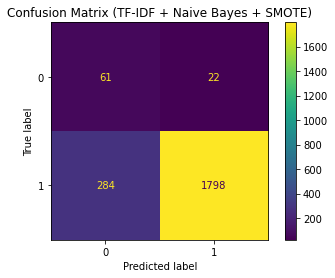

In [8]:
#####✅ PART 5: Evaluate Model on Unseen Test Data
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test_tfidf)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix (TF-IDF + Naive Bayes + SMOTE)")
plt.show()
